In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, chi2_contingency
from statistics import mean

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Previews

In [4]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Inspection

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
train_data.loc[train_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [11]:
train_data.loc[train_data['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


# Single Feature Summaries

## Age Summary

<Axes: xlabel='Age'>

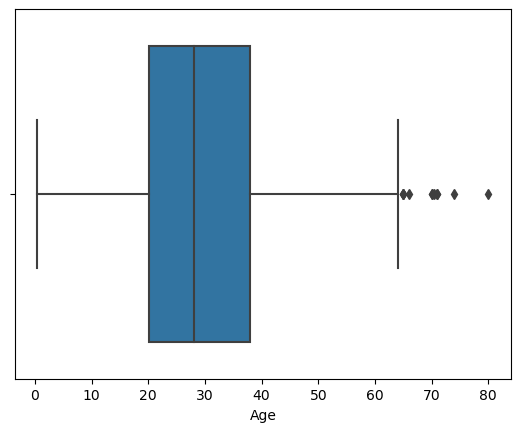

In [12]:
sns.boxplot(data=train_data, x='Age')

## Fare Summary

<Axes: xlabel='Fare'>

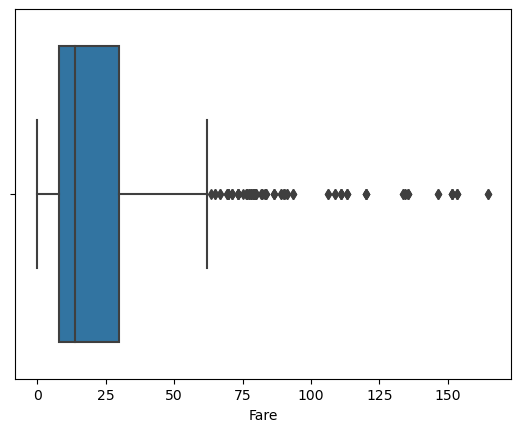

In [13]:
sns.boxplot(data=train_data.loc[train_data['Fare'] < 200], x='Fare')

## Passenger Class Summary

[Text(0, 0, '24.24%'), Text(0, 0, '20.65%'), Text(0, 0, '55.11%')]

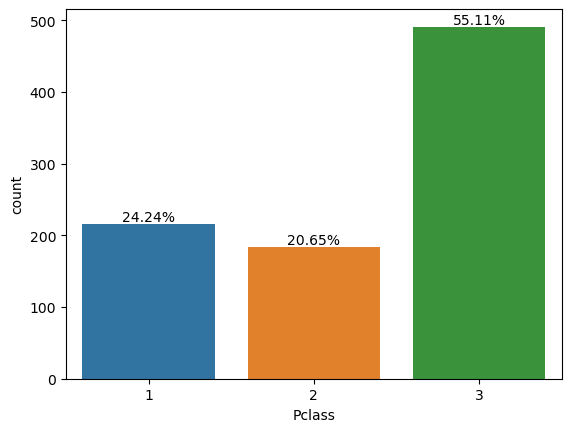

In [14]:
ax = sns.countplot(data=train_data, x='Pclass')

total = train_data['Pclass'].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')

## Sex Summary

[Text(0, 0, '64.76%'), Text(0, 0, '35.24%')]

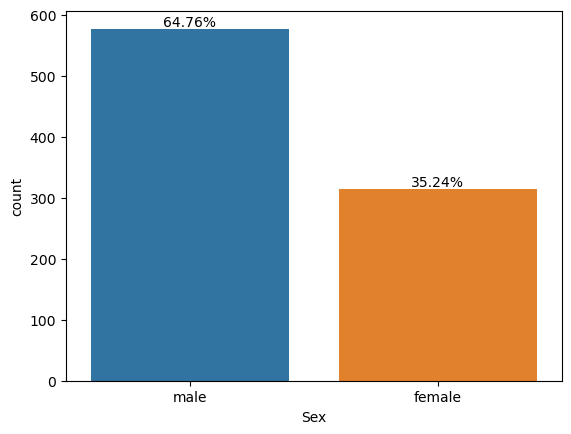

In [15]:
ax = sns.countplot(data=train_data, x='Sex')

total = train_data['Sex'].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')

## No. Siblings/Spouses Summary

[Text(0, 0, '68.24%'),
 Text(0, 0, '23.46%'),
 Text(0, 0, '3.14%'),
 Text(0, 0, '1.80%'),
 Text(0, 0, '2.02%'),
 Text(0, 0, '0.56%'),
 Text(0, 0, '0.79%')]

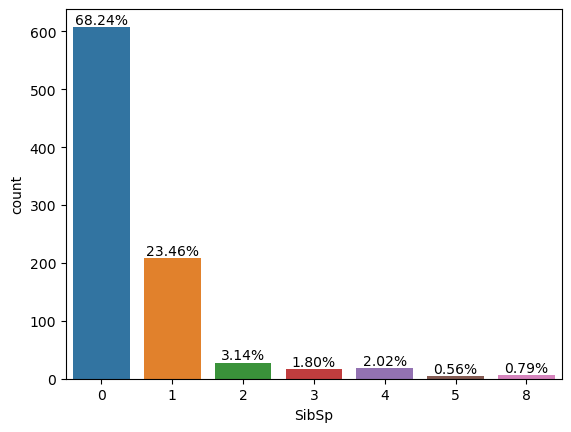

In [16]:
ax = sns.countplot(data=train_data, x='SibSp')

total = train_data['SibSp'].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')

## No. Parents/Children Summary

[Text(0, 0, '76.09%'),
 Text(0, 0, '13.24%'),
 Text(0, 0, '8.98%'),
 Text(0, 0, '0.56%'),
 Text(0, 0, '0.45%'),
 Text(0, 0, '0.56%'),
 Text(0, 0, '0.11%')]

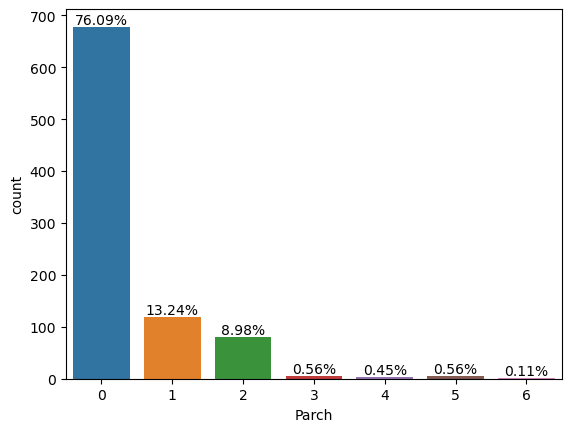

In [17]:
ax = sns.countplot(data=train_data, x='Parch')

total = train_data['Parch'].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')

## Port Embarked Summary

[Text(0, 0, '72.44%'), Text(0, 0, '18.90%'), Text(0, 0, '8.66%')]

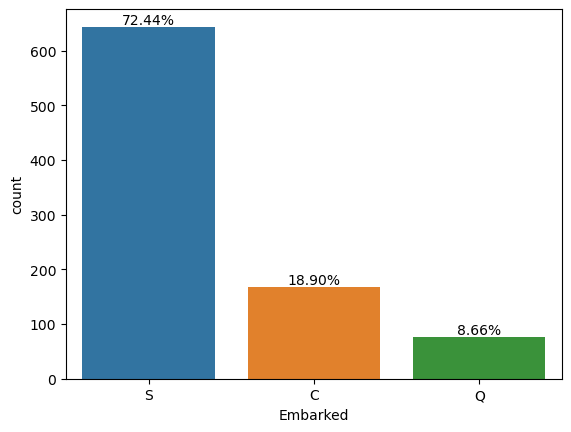

In [18]:
ax = sns.countplot(data=train_data, x='Embarked')

total = train_data['Embarked'].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.2f}%')

# Two Feature Summaries (Survival)

## Survival by Age

Text(0.5, 1.0, 'Survival by Age')

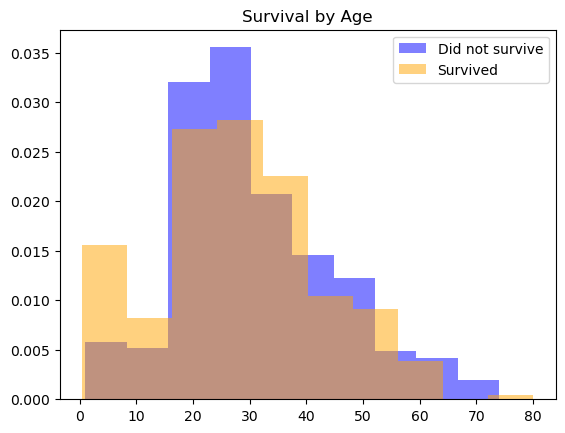

In [19]:
plt.hist(train_data.loc[train_data['Survived'] == 0]['Age'], label='Did not survive', color='blue', alpha=0.5, density=True)
plt.hist(train_data.loc[train_data['Survived'] == 1]['Age'], label='Survived', color='orange', alpha=0.5, density=True)
plt.legend()
plt.title('Survival by Age')

Text(0.5, 1.0, 'Survival by Age')

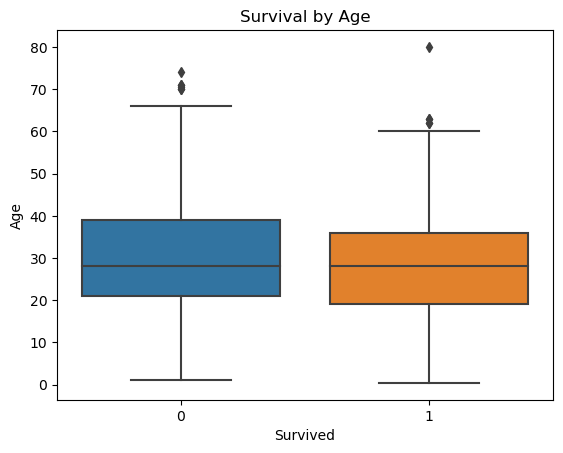

In [20]:
sns.boxplot(data=train_data, x='Survived', y='Age')
plt.title('Survival by Age')

## Survival by Fare

Text(0.5, 1.0, 'Survival by Fare')

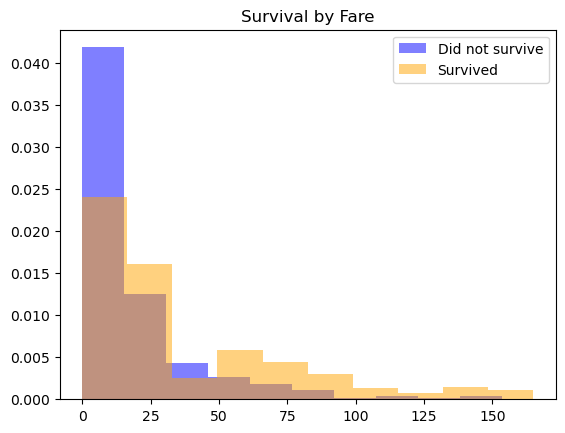

In [21]:
train_data_farefilt = train_data.loc[train_data['Fare'] < 200]

plt.hist(train_data_farefilt.loc[train_data_farefilt['Survived'] == 0]['Fare'], label='Did not survive', color='blue', alpha=0.5, density=True)
plt.hist(train_data_farefilt.loc[train_data_farefilt['Survived'] == 1]['Fare'], label='Survived', color='orange', alpha=0.5, density=True)
plt.legend()
plt.title('Survival by Fare')

Text(0.5, 1.0, 'Survival by Fare')

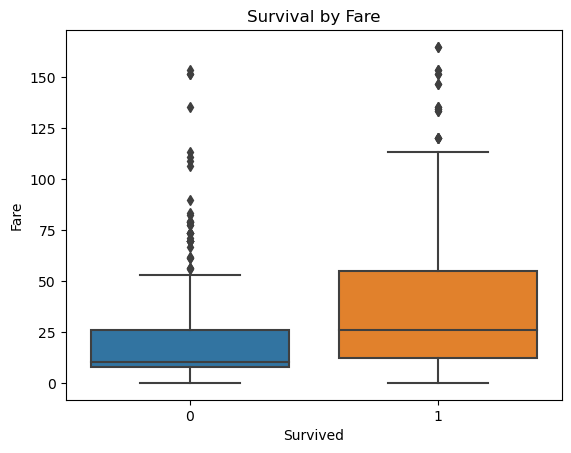

In [22]:
sns.boxplot(data=train_data_farefilt, x='Survived', y='Fare')
plt.title('Survival by Fare')

## Survival by Passenger Class

In [23]:
pclass_survived_freq = pd.crosstab(train_data['Pclass'], train_data['Survived'])
pclass_survived_freq

# round(pclass_survived_freq * 100 / len(train_data['Survived']), 2)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [24]:
pclass_survived_exp = pd.DataFrame(chi2_contingency(pclass_survived_freq)[3])
round(pclass_survived_exp)

,0,1
0,133.0,83.0
1,113.0,71.0
2,303.0,188.0


In [25]:
pclass_survived_chi2 = chi2_contingency(pclass_survived_freq)[0]
pclass_survived_chi2

102.88898875696056

## Survival by Sex

In [26]:
sex_survived_freq = pd.crosstab(train_data['Sex'], train_data['Survived'])
sex_survived_freq

Survived,0,1
Sex,,
female,81,233
male,468,109


In [27]:
sex_survived_exp = pd.DataFrame(chi2_contingency(sex_survived_freq)[3])
round(sex_survived_exp)

,0,1
0,193.0,121.0
1,356.0,221.0


In [28]:
sex_survived_chi2 = chi2_contingency(sex_survived_freq)[0]
sex_survived_chi2

260.71702016732104

## Survival by No. Siblings/Spouses

In [29]:
sibsp_survived_freq = pd.crosstab(train_data['SibSp'], train_data['Survived'])
sibsp_survived_freq

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


In [30]:
sibsp_survived_exp = pd.DataFrame(chi2_contingency(sibsp_survived_freq)[3])
round(sibsp_survived_exp)

,0,1
0,375.0,233.0
1,129.0,80.0
2,17.0,11.0
3,10.0,6.0
4,11.0,7.0
5,3.0,2.0
6,4.0,3.0


In [31]:
sibsp_survived_chi2 = chi2_contingency(sibsp_survived_freq)[0]
sibsp_survived_chi2

37.2717929152043

## Survival by No. Parents/Children

In [32]:
parch_survived_freq = pd.crosstab(train_data['Parch'], train_data['Survived'])
parch_survived_freq

Survived,0,1
Parch,,
0,445,233
1,53,65
2,40,40
3,2,3
4,4,0
5,4,1
6,1,0


In [33]:
parch_survived_exp = pd.DataFrame(chi2_contingency(parch_survived_freq)[3])
round(parch_survived_exp)

,0,1
0,418.0,260.0
1,73.0,45.0
2,49.0,31.0
3,3.0,2.0
4,2.0,2.0
5,3.0,2.0
6,1.0,0.0


In [34]:
parch_survived_chi2 = chi2_contingency(parch_survived_freq)[0]
parch_survived_chi2

27.925784060236168

## Survival by Port Embarked

In [35]:
embarked_survived_freq = pd.crosstab(train_data['Embarked'], train_data['Survived'])
embarked_survived_freq

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


In [36]:
embarked_survived_exp = pd.DataFrame(chi2_contingency(embarked_survived_freq)[3])
round(embarked_survived_exp)

,0,1
0,104.0,64.0
1,48.0,29.0
2,398.0,246.0


In [37]:
embarked_survived_chi2 = chi2_contingency(embarked_survived_freq)[0]
embarked_survived_chi2

26.48914983923762

# Cleaning

In [38]:
train_data_unclean = train_data

pclass_age_mean = train_data.groupby('Pclass')['Age'].mean()
train_data['Age'] = train_data.apply(lambda row: pclass_age_mean[row['Pclass']] if pd.isna(row['Age']) else row['Age'], axis=1)
embarked_fare_mean = train_data.groupby('Embarked')['Fare'].mean()
train_data['Embarked'] = train_data.apply(lambda row:
                                          (embarked_fare_mean - row['Fare']).abs().idxmin() if pd.isna(row['Embarked']) else row['Embarked'], axis=1)

train_data = train_data.dropna(axis=1)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


# Data Selection

In [47]:
y = train_data['Survived']
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Sex', 'Embarked']

features_list = numerical_features + categorical_features

X_incl_categorical = train_data[features_list]
X = pd.get_dummies(X_incl_categorical, columns=categorical_features)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.5, random_state=1)

# Model Training and Tuning

In [40]:
n_estim_vals = [250]
max_feat_vals = ['sqrt']
max_dep_vals = [10]
min_samp_split_vals = [4]
max_leaf_vals = [None]
crit_vals = ['gini']

tests = 20
test_acc_list = [0 for _ in range(tests)]
results_list = []

for n_estim_val in n_estim_vals:
    for max_feat_val in max_feat_vals:
        for max_dep_val in max_dep_vals:
            for min_samp_split_val in min_samp_split_vals:
                for max_leaf_val in max_leaf_vals:
                    for crit_val in crit_vals:
                        for test in range(tests):
                            model = RandomForestClassifier(random_state=test, n_estimators=n_estim_val, max_features=max_feat_val, max_depth=max_dep_val,
                                                           min_samples_split=min_samp_split_val, max_leaf_nodes=max_leaf_val, criterion=crit_val)
                            model.fit(train_X, train_y)
                            pred_y = model.predict(val_X)
                            test_acc_list[test] = accuracy_score(val_y, pred_y)

                        acc = round(mean(test_acc_list), 6)
                        results_list.append([acc, n_estim_val, max_feat_val, max_dep_val, min_samp_split_val, max_leaf_val, crit_val])

results = pd.DataFrame(results_list, columns=['Accuracy', 'n_estimators', 'max_features', 'max_depth', 'min_samples_split', 'max_leaf_nodes', 'criterion'])
print("Complete")

Complete


In [41]:
print(results.sort_values('Accuracy', ascending=False).head(20))

   Accuracy  n_estimators max_features  max_depth  min_samples_split  \
0  0.807511           250         sqrt         10                  4   

  max_leaf_nodes criterion  
0           None      gini  


In [48]:
repeats = 20
aggr_acc_list = [0 for _ in range(repeats)]

for repeat in range(repeats):
    model = RandomForestClassifier(random_state=repeat, n_estimators=250, max_depth=10, min_samples_split=4)
    model.fit(train_X, train_y)
    pred_y = model.predict(val_X)
    aggr_acc_list[repeat] = accuracy_score(val_y, pred_y)

aggr_accuracy = mean(aggr_acc_list)
print(f"Aggregated accuracy ({repeats} repeat(s)): {aggr_accuracy * 100:.4f}%")

Aggregated accuracy (20 repeat(s)): 80.5157%


# Final Prediction and Submission

In [49]:
full_model = RandomForestClassifier(n_estimators=250, max_depth=10, min_samples_split=4)
full_model.fit(X, y)

test_data_path = '../input/titanic/test.csv'
test_data = pd.read_csv(test_data_path)

embarked_fare_mean = test_data.groupby('Embarked')['Fare'].mean()
test_data['Fare'] = test_data.apply(lambda row: embarked_fare_mean[row['Embarked']] if np.isnan(row['Fare']) else row['Fare'], axis=1)
pclass_age_mean = test_data.groupby('Pclass')['Age'].mean()
test_data['Age'] = test_data.apply(lambda row: pclass_age_mean[row['Pclass']] if np.isnan(row['Age']) else row['Age'], axis=1)

test_X_w_categorical = test_data[features_list]
test_X = pd.get_dummies(test_X_w_categorical, columns=categorical_features)

test_preds = full_model.predict(test_X)

In [44]:
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_preds})
output.to_csv('submission.csv', index=False)